In [1]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [72]:
import pandas as pd
from urlparse import urlparse
import tldextract
from collections import Counter
import jieba
import json
import math
import numpy as np
from time import time

In [30]:
huizhou_stop_words = [u'的', u'了', u'在', u'是', u'安徽', u'和', u'有', u'我', u'年', u'上', u'他', u'我们', 
                      u'为', u'与', u'人', u'也', u'于', u'中', u'就', u'都', u'在线', u'等', u'不', u'网站', u'你', 
                      u'一个', u'到', u'之', u'对', u'说', u'进入', u'后', u'月', u'将', u'时', u'又', u'被', u'会员'
                     u'版权', u'论坛', u'以', u'而', u'着', u'下', u'这', u'但', u'要', u'或', u'首页', u'这',
                     u'地', u'从', u'卡', u'来', '多', u'日', u'她', u'还', u'联系', u'那', u'一处', u'一直', u'个', 
                     u'向', u'并', u'曾', u'这样', u'里', u'合肥', u'推荐', u'专栏', u'相关', u'当前', u'所有', u'中心'
                     u'频道', u'编辑', u'位置', u'第一', u'社区', u'看', '中安', u'安徽省', u'大', u'许可证', u'许可',
                     u'让', u'没有', u'什么', u'其', '请', '该', '用', '积分', u'凤阳', u'一篇', u'版权', u'县']

In [18]:
class Toolbox (object):
    def __init__(self):
        self.init = 1
        
    def sort_dict (self, d, max=50):
        t = sorted(d.items(), key=lambda x: (-x[1], x[0]))
        return t[:max]
    
    def add_dict (self, x, y):
        d = { k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y) }
        return d
    
    def create_dict(self, k1, v1, filters = True):
        if filters == True:
            k1_list0 = k1.strip('()').split(',')
            v1_list0 = v1.strip('()').split(',')
            #print v1_list0
            #print k1_list0
            k1_list1 = filter(None, k1_list0)        
            v1_list1 = filter(None, v1_list0)
        else:
            k1_list1 = k1
            v1_list1 = v1
        
        #print ' '.join(k1_list1)
        k2_list1 = [item.decode('utf-8') for item in k1_list1]
        v2_list1 = [float(item) for item in v1_list1]

    def create_vec(self, k1, v1):
        return (zip(k1, v1))
    
    def get_dict_top_n(self, d, max=50):
        ret = self.sort_dict(d, max)
        words, fq = zip(*ret)
        sum_up = sum(fq)
        fq_normalized = tuple(item/sum_up for item in fq)
        
        return dict(zip(words, fq_normalized))
    
    #calculate cosine between two dictionaries
    def get_sim(self, vec1, vec2):
        
        #get intersection
        intersection = set(vec1.keys()) & set(vec2.keys())
        
        #print intersection
        numerator = sum([vec1[x] * vec2[x] for x in intersection])

        #print 'num ---', numerator
        #print vec1.keys()
        #print vec1.values()
        #print vec2.keys()
        #print vec2.values()        
        
        if numerator == 0:
            return 0.0
        
        sum1 = sum([vec1[x]**2 for x in vec1.keys()])
        sum2 = sum([vec2[x]**2 for x in vec2.keys()])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)

        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator
        
    def sum_vects(self, vects):
        sum_vects = None
        for vec in vects:
            if sum_vects == None:
                sum_vects = vec
            else:
                sum_vects = self.add_dict(sum_vects, vec)
        #only return first 100 after additions
        #print type(sum_vecs)
        return self.get_dict_top_n(sum_vects)
    
    def unserialized(self, x, eval_val=True):
        #print '----- in'
        #print x
        d = dict()
        s = x.strip('{}')
        #s = s.strip('[]')
        ret = s.split(',')

        #print ret
        for t in ret:
            r = t.split(':')
            #print r[0], r[1]
            key = eval(r[0].decode('utf-8'))
            if eval_val == True:
                d[key] = int(r[1])
            else:
                d[key] = r[1]
        #print len(ret)
        #print 'split -----'
        #print ' '.join(ret)
        return d
        
    def get_centroid_df(self, check, t_sim, num=2000):        
        if len(check) > num:
            #sampling     
            ratio = num*1.0/len(check)
            print 'ratio ---', ratio 
            msk = np.random.rand(len(check)) < ratio
            tmp = check[msk]
            check = tmp
    
        check.info()
        check_vecs = check['s_vec']
        return self.sum_vects(check_vecs) 
    
    def set_contained_flag(self, x, y):
        x_keys = x.keys()
        y_keys = y.keys()
        for s in y_keys:
            if s in x_keys:
                return True
        return False

In [16]:
aT = Toolbox()

In [259]:
df = pd.read_csv('/Users/nhu2000/projects/SimilarSearch/data/clean/huizhou-web-full_v1_3.csv')

In [262]:
df.info()

In [263]:
#unseralized
t0 = time()
df['s_vec'] = df.s_vec.map(lambda x: aT.unserialized(x))
print (time() - t0)

In [264]:
#create similarity matrix

In [308]:
sim_mat = np.zeros(shape=(len(df),len(df)))

In [310]:
t0 = time()
for i in range (0, len(df)):
    for j in range (i, len(df)):
        v1 = df.iloc[i]['s_vec']
        v2 = df.iloc[j]['s_vec']
        sim_mat[i][j] = aT.get_sim(v1, v2)
        sim_mat[j][i] = sim_mat[i][j]
print (time() - t0)

In [321]:
sim_mat[1][2001], sim_mat[2001][1]

(0.28809220426060411, 0.28809220426060411)

In [337]:
dist = 1.0 - sim_mat

In [265]:
orig_df = pd.read_csv('/Users/nhu2000/projects/SimilarSearch/data/final/huizhou-final-v2.csv')

In [323]:
dict

(2190, 665)

In [266]:
def get_content_seg_by_url(url):
    df = orig_df[orig_df['url'] == url]
    return df.iloc[0]['content_seg']

In [267]:
df['content_seg'] = df.url.map(lambda x: get_content_seg_by_url(x))

In [268]:
articles = df['content_seg']

In [269]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer = 'word', max_df=0.8, min_df=0.08, use_idf=True, stop_words = huizhou_stop_words, max_features=200000,)
document_term_mat = vectorizer.fit_transform(articles)
terms = vectorizer.get_feature_names()

In [331]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer = 'word', max_df=0.8, min_df=0.08, use_idf=False, stop_words = huizhou_stop_words, max_features=200000,)
document_term_mat = vectorizer.fit_transform(articles)
terms = vectorizer.get_feature_names()

In [332]:
from sklearn.metrics.pairwise import cosine_similarity
sim_max = cosine_similarity(document_term_mat)

In [333]:
dist = 1 - sim_max

In [341]:
sim_max[1][2001], sim_max[2001][1]

(0.075425468273140353, 0.075425468273140353)

In [342]:
sim_max[2][2]

1.0

In [250]:
print (document_term_mat.shape)

In [271]:
vocab_frame = pd.DataFrame({'words': terms})

In [272]:
from sklearn.cluster import KMeans
num_clusters = 9
km = KMeans(n_clusters=num_clusters)
%time km.fit(document_term_mat)
clusters = km.labels_.tolist()

In [273]:
df['cluster'] = clusters

In [305]:
df.info()

In [275]:
df['cluster'].value_counts()

0    801
3    293
2    268
6    231
1    179
5    172
4    126
7     79
8     41
Name: cluster, dtype: int64

In [209]:
df.to_csv('/Users/nhu2000/projects/SimilarSearch/data/clean/huizhou-web-full_v1_4.csv', encoding='utf-8', index=False)

In [339]:
from __future__ import print_function
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i)
    
    for ind in order_centroids[i, :20]: #replace 6 with n words per cluster
        print (terms[ind])       
        #print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
    print() #add whitespace
    print() #add whitespace
    

In [257]:
#Multidimensional scaling
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib 

from sklearn.manifold import MDS

In [338]:
MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs_full, ys_full = pos[:, 0], pos[:, 1]
print()
print()

In [303]:
#set up colors per clusters using a dict
cluster_colors = {0: '#8f9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e78181', 4: '#66a61e',
                  5: '#fb0877', 6: '#065f06', 7: '#f570b3', 8: '#08848a', 9: '#a4a4a4',
                 }

#set up cluster names using a dict
cluster_names = {5: u'徽学', 
                 4: u'文化保护', 
                 2: u'徽商', 
                 0: u'新安理学', 
                 8: u'徽菜',  
                 3: u'徽州民俗', 
                 6: u'徽派建筑', 
                 1: u'徽州文化',  
                 7: u'古今徽州'
                 }

#set up colors per clusters using a dict
cluster_colors = {0: '#8f9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e78181', 4: '#66a61e',
                  5: '#fb0877', 6: '#065f06', 7: '#f570b3', 8: '#08848a', 9: '#a4a4a4',
                 }

#set up cluster names using a dict
cluster_names = {0: 'Topics 0', 
                 1: 'Topics 1', 
                 2: 'Topics 2', 
                 3: 'Topics 3', 
                 4: 'Topics 4',  
                 5: 'Topics 5', 
                 6: u'徽派建筑', 
                 7: u'徽州文化',  
                 8: u'古今徽州'
                 }

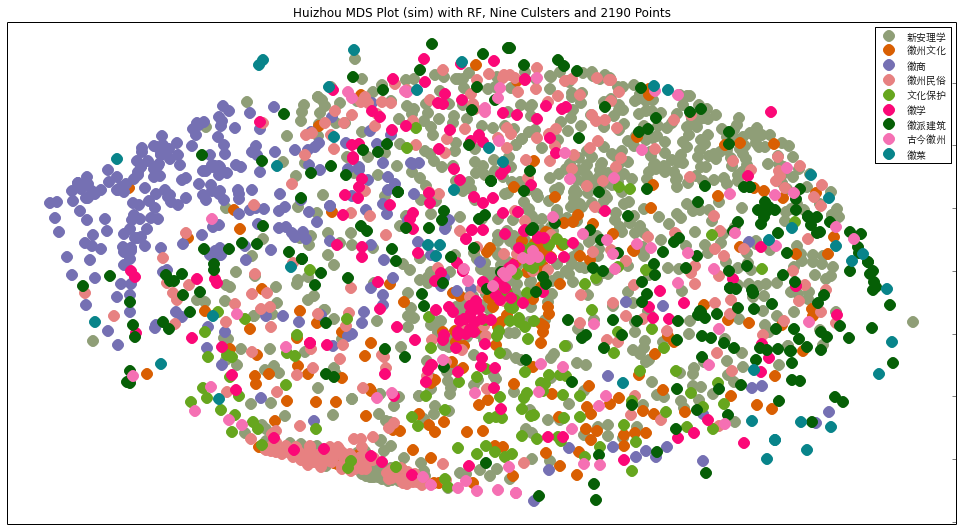

In [340]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

from matplotlib.font_manager import FontManager

myfont = matplotlib.font_manager.FontProperties(fname='/System/Library/Fonts/STHeiti Light.ttc')


#plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
    

#create data frame that has the result of the MDS plus the cluster numbers and titles
#df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
#df_plot = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
df_plot = pd.DataFrame(dict(x=xs_full, y=ys_full, label=clusters)) 


#group by cluster
groups = df_plot.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

idx = 0
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    if 1: #idx == 2 or idx == 3 or idx == 0:
        
        #ax.legend(prop=myfont)

        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=cluster_names[name], color=cluster_colors[name], 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')
    idx += 1 

#ax.legend(numpoints=1)  #show legend with only 1 point
ax.legend(numpoints=1, prop=myfont)  #show legend with only 1 point

plt.title('Huizhou MDS Plot (sim) with RF, Nine Culsters and 2190 Points ')

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], size=8)  #Not draw the titles

    
    
#plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('huizhou_clusters_raw.png')


In [301]:
draw_df = df[df['cluster'] == 6]

In [302]:
for i in range (0, len(draw_df)):
    t = draw_df.iloc[i]['title']
    print (i, t)